In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.constants import e, hbar
from two_coupled_qubits import ChargeQubit, capacitance, critical_current, Phi_0

<h3>Parameters</h3>

In [2]:
# Flux parameters
Phi_ext = np.linspace(0, 2 * Phi_0 / 3, 500)
phi_e = np.pi * Phi_ext/Phi_0

# Qubit 1
q1 = {
    'E_C': 0.23084,
    'E_J': 16.34,
}

q1['w'] = 2 * np.pi * (np.sqrt(8 * q1['E_J'] * q1['E_C']) - q1['E_C'])
q1['C_s'] = capacitance(q1['E_C'])
q1['I_c'] = critical_current(q1['E_J'])

# Qubit 2
q2 = {
    'E_C': 0.23084,
    'E_J': 16.34,
    #'E_J': 2 * 16.34 * np.abs(np.cos(phi_e)),
}

q2['w'] = 2 * np.pi * (np.sqrt(8 * q2['E_J'] * q2['E_C']) - q2['E_C'])
q2['C_s'] = capacitance(q2['E_C'])
q2['I_c'] = critical_current(q2['E_J'])

# Resonator
r = {
    'n': 5,
    'w': 2 * np.pi * 5.19,
    'C_r': 368.440,
}

r['V_rms'] = np.sqrt((hbar * r['w'] * 1e9) / (2 * r['C_r'] * 1e-15))

# Couplings
C_g = 4.643
beta = [C_g/(C_g + q1['C_s']), C_g/(C_g + q1['C_s'])]
g_1 = np.sqrt(1) * 2 * beta[0] * e * r['V_rms'] / hbar * (q1['E_J'] / (32 * q1['E_C']))**(1/4) * 1e-9
g_2 = np.sqrt(1) * 2 * beta[1] * e * r['V_rms'] / hbar * (q2['E_J'] / (32 * q2['E_C']))**(1/4) * 1e-9
Delta_1 = q1['w'] - r['w']
Delta_2 = q2['w'] - r['w']
J = g_1 * g_2 * (1 / Delta_1 + 1 / Delta_2) / 2

# Dispersive regime
Chi_1 = g_1 / Delta_1
Chi_2 = g_2 / Delta_2

<h1>Computational basis</h1>

In [7]:
# Operators
a = destroy(r['n'])

# Free hamiltonians
H_1 = q1['w']/2 * sigmaz() + Chi_1 * sigmaz()
H_2 = q2['w']/2 * sigmaz() + Chi_2 * sigmaz()
H_r = r['w'] * a.dag() * a
H_0 = tensor(H_1, H_2, H_r)

# Interacting hamiltonian
H_int = J * (tensor(sigmam(), sigmap(), qeye(r['n'])) + tensor(sigmap(), sigmam(), qeye(r['n'])))

# Total hamiltonian
H_tot = H_0 + H_int

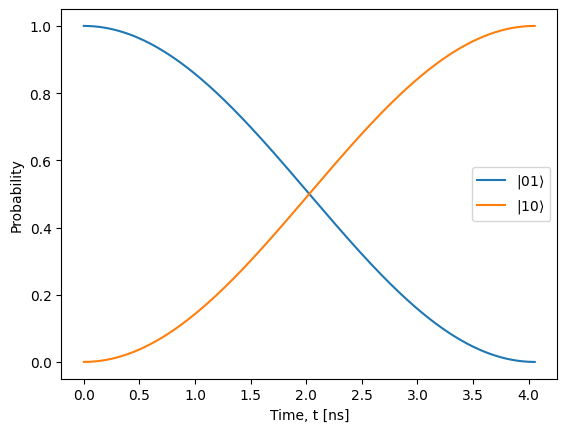

In [8]:
# Initial state
psi_01 = tensor(basis(2, 0), basis(2, 1), basis(r['n'], 0))
psi_10 = tensor(basis(2, 1), basis(2, 0), basis(r['n'], 0))

# Time
t_list = np.linspace(0, np.pi/(2*J), 1000)

# Master Equation
result = mesolve(H=H_tot, rho0=psi_01, tlist=t_list, c_ops=[], e_ops=[], args={})
prob_01 = expect(psi_01*psi_01.dag(), result.states)
prob_10 = expect(psi_10*psi_10.dag(), result.states)

plt.plot(t_list, prob_01, label="$|01\\rangle$")
plt.plot(t_list, prob_10, label="$|10\\rangle$")
plt.ylabel("Probability")
plt.xlabel("Time, t [ns]")
plt.legend()
plt.show()

<h1>Charge basis</h1>

In [14]:
# Parameters
a = destroy(r['n'])
levels = 3
n_g = 0.

# Free hamiltonians
transmon_1 = ChargeQubit(q1['E_C'], q1['E_J'], levels, n_g)
transmon_2 = ChargeQubit(q2['E_C'], q2['E_J'], levels, n_g)
H_1 = transmon_1.hamiltonian
H_2 = transmon_2.hamiltonian

eigenvalues_1, eigenvectors_1 = H_1.eigenstates()
eigenvalues_2, eigenvectors_2 = H_2.eigenstates()

# Operators
sm1 = eigenvectors_1[0] * eigenvectors_1[1].dag()
sm2 = eigenvectors_2[0] * eigenvectors_2[1].dag()
sz1 = eigenvectors_1[0] * eigenvectors_1[0].dag() - eigenvectors_1[1] * eigenvectors_1[1].dag() 
sz2 = eigenvectors_2[0] * eigenvectors_2[0].dag() - eigenvectors_2[1] * eigenvectors_2[1].dag() 

H_r = r['w'] * a.dag() * a
H_0 = tensor(H_1 - Chi_1 * sz1, H_2 - Chi_2 * sz2, H_r)

# Interacting hamiltonian
H_int = J * (tensor(sm1, sm2.dag(), qeye(r['n'])) + tensor(sm1.dag(), sm2, qeye(r['n'])))

# Total hamiltonian
H_tot = H_0 + H_int

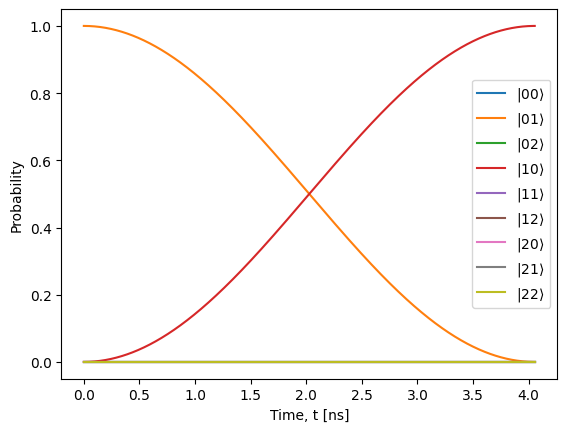

In [19]:
# Initial state
psi_00 = tensor(eigenvectors_1[0], eigenvectors_2[0], basis(r['n'], 0))
psi_01 = tensor(eigenvectors_1[0], eigenvectors_2[1], basis(r['n'], 0))
psi_02 = tensor(eigenvectors_1[0], eigenvectors_2[2], basis(r['n'], 0))
psi_10 = tensor(eigenvectors_1[1], eigenvectors_2[0], basis(r['n'], 0))
psi_11 = tensor(eigenvectors_1[1], eigenvectors_2[1], basis(r['n'], 0))
psi_12 = tensor(eigenvectors_1[1], eigenvectors_2[2], basis(r['n'], 0))
psi_20 = tensor(eigenvectors_1[2], eigenvectors_2[0], basis(r['n'], 0))
psi_21 = tensor(eigenvectors_1[2], eigenvectors_2[1], basis(r['n'], 0))
psi_22 = tensor(eigenvectors_1[2], eigenvectors_2[2], basis(r['n'], 0))

# Time
t_list = np.linspace(0, np.pi/(2*J), 1000)

# Master Equation
result = mesolve(H=H_tot, rho0=psi_01, tlist=t_list, c_ops=[], e_ops=[], args={})
prob_00 = expect(psi_00*psi_00.dag(), result.states)
prob_01 = expect(psi_01*psi_01.dag(), result.states)
prob_02 = expect(psi_02*psi_02.dag(), result.states)
prob_10 = expect(psi_10*psi_10.dag(), result.states)
prob_11 = expect(psi_11*psi_11.dag(), result.states)
prob_12 = expect(psi_12*psi_12.dag(), result.states)
prob_20 = expect(psi_20*psi_20.dag(), result.states)
prob_21 = expect(psi_21*psi_21.dag(), result.states)
prob_22 = expect(psi_22*psi_22.dag(), result.states)

plt.plot(t_list, prob_00, label="$|00\\rangle$")
plt.plot(t_list, prob_01, label="$|01\\rangle$")
plt.plot(t_list, prob_02, label="$|02\\rangle$")
plt.plot(t_list, prob_10, label="$|10\\rangle$")
plt.plot(t_list, prob_11, label="$|11\\rangle$")
plt.plot(t_list, prob_12, label="$|12\\rangle$")
plt.plot(t_list, prob_20, label="$|20\\rangle$")
plt.plot(t_list, prob_21, label="$|21\\rangle$")
plt.plot(t_list, prob_22, label="$|22\\rangle$")
plt.ylabel("Probability")
plt.xlabel("Time, t [ns]")
plt.legend()
plt.show()